# Setup

In [18]:
import numpy as np
import pandas as pd
import chama
from tqdm import tqdm
from sympy import symbols, solve
import matplotlib.pyplot as plt
import time
import csv
from psmodules import psarray, pssynthetic, psraytrace, pswavelet, \
    psplot, pspicker, pspdf

def Wasserstein_upper_bound(distribution, num_bins=10, gamma=0.9):
    # distribution: empirical distribution
    # gamma: Confidence level
    # (high gamma, more sample)->high shift
    distribution = np.array(distribution)
    len_distribution = float(distribution.__len__())
    S = len_distribution # Number of historical data for empirical distribution
    # H = len_distribution # Number of bins for empirical distribution
    H = num_bins # Number of bins for empirical distribution

    kappa = (H / (2 * S)) * np.log(2 * H / (1 - gamma))

    # solve |x-d| = kappa wasserstein function (quadratic function choose max solution)
    dro_det_time = symbols('dro_det_time')
    a = len_distribution
    b = -2 * np.sum(distribution)
    c = np.sum(distribution ** 2) - (kappa * len_distribution) ** 2
    f = a * dro_det_time ** 2 + b * dro_det_time + c
    result = solve(f)
    result = complex(result[-1]).real
    return result


def sample_velocity_model(num_samples, vp_mean, vp_std):
    """sample wind speed traces from normal distribution(assumed true distribution of wind speed)"""
    vp_samples = []
    for sample_idx in range(num_samples):
        vp_trace = []
        for i, (wind_speed_time_point) in enumerate(zip(vp_mean)):
            vp_trace.append(np.random.normal(wind_speed_time_point, vp_std)[0])
        vp_samples.append(vp_trace)
    return vp_samples


def prepare_forward_input(geox, geoy, geoz, src_gt, zlayer, vp):
    """
    prepare_forward_input(): format input for forward simulation.
    geox:array, geoy:array, geoz:array-coordinates of geophones|output of psarray.gridarray function
    src_gt:list-coordinates of microseismic source
    zlayer:list-depth of strata
    vp:list-p wave velocity of strata
    """
    vp = np.array(vp)
    sourcex = np.array([src_gt[0]])
    sourcey = np.array([src_gt[1]])
    sourcez = np.array([src_gt[2]])

    # observation forward
    nt = len(geox)
    #  S wave velocity based on Castagna's rule
    # vs = (vp - 1360) / 1.16
    #  S wave velocity based on literature:
    #  2019 Optimal design of microseismic monitoring network: Synthetic study for the Kimberlina CO2 storage demonstration site
    vs = vp / 1.73

    # 3D passive seismic raytracing
    dg = 10
    src = np.array([sourcex, sourcey, sourcez]).T
    rcv = np.array([geox, geoy, geoz]).T
    return vp, vs, zlayer, dg, src, rcv


class SingleEventForwarder():
    def __init__(self, vp, vs, zlayer, dg, rcv):
        self.ptimes_obs = None  # instance variable unique to each instance
        self.forward_counter = 0  # instance variable unique to each instance
        self.vp = vp
        self.vs = vs
        self.zlayer = zlayer
        self.dg = dg
        self.rcv = rcv

    def forward_obs(self, gt_src):
        """
        forward_obs(): forward simulation to get the observation ground truth seismic event arrival time.

        """

        start_time = time.time()
        # print("3D passive seismic raytracing is running[Waiting...]")
        tps, _, tetas = psraytrace.raytrace(self.vp, self.vs, self.zlayer, self.dg, gt_src, self.rcv)
        self.ptimes_obs = tps
        self.forward_counter = self.forward_counter + 1

        # print("3D passive seismic raytracing completed[OK]")
        # print("running time: " + str((time.time() - start_time) / 50) + ' mins')
        return tps

    def timediff(self, tp, tmp):
        """
        timediff(): microseismic event location method based on arrival time differences.
        This method needs to pick first arrival times of microseismic event and
        generally aims to process high signal-to-noise ratio.

        """
        tpdiff = abs(np.diff(tp, axis=0))
        tmpdiff = abs(np.diff(tmp, axis=0))

        temp = np.square(tpdiff - tmpdiff)
        sumErrs = np.cumsum(temp)
        minErr = sumErrs[len(sumErrs) - 1]
        return minErr

    def forward_source_pred_error(self, pre_src):
        """
        time_diff_Err(): try different source location to see error of simulated arrival time.

        """
        sx = [pre_src[0][0]]
        sy = [pre_src[1][0]]
        sz = [pre_src[2][0]]

        if sz[0] in self.zlayer + 1:
            sz[0] = sz[0] + 1

        try_src = np.array([sx, sy, sz]).T

        # print('try_src: ', try_src)
        # print("3D passive seismic raytracing example is running[Waiting...]")
        tps, _, tetas = psraytrace.raytrace(self.vp, self.vs, self.zlayer, self.dg, try_src, self.rcv)
        self.forward_counter = self.forward_counter + 1
        # print("3D passive seismic raytracing completed[OK]")
        # tps = tps / dt

        minErr = self.timediff(tps, self.ptimes_obs)

        return float(minErr)


def seismic_event_simulation(vp, event_positions,geo_sensor_candidates_positions, zlayer, e_name='Event'):
    """input: grid, atmosphere model, leak lists"""
    Sensor_name_list = []
    Impact_list = []
    Scenario_name_list = []


    fault_x = event_positions[0]
    fault_y = event_positions[1]
    fault_z = event_positions[2]

    for i in range(len(fault_x)):
        event_name = e_name + '_' + str(int(fault_x[i])) + '_' + str(int(fault_y[i])) + '_' + str(int(fault_z[i]))
        # Generate square grid array
        geox, geoy, geoz = geo_sensor_candidates_positions[0], geo_sensor_candidates_positions[1], geo_sensor_candidates_positions[2]
        # # Define geological model
        # zlayer = np.array([0, 540, 1070, 1390, 1740, 1950, 2290,
        #                    2630, 4000])

        # Define source coordinates
        source = [fault_x[i], fault_y[i], fault_z[i]]


        # Define velocity model
        # P wave velocity
        # vp = vp

        # formatting the input for forward
        vp, vs, zlayer, dg, src, rcv = prepare_forward_input(geox, geoy, geoz, source, zlayer, vp)

        # run forward simulation
        forwarder = SingleEventForwarder(vp, vs, zlayer, dg, rcv)
        event_min_detect_time = forwarder.forward_obs(src)

        # each sensor's record
        for sensor_idx in range(len(geox)):
            name_sensor = 'sensor_' + str(int(geox[sensor_idx])) + '_' + str(int(geoy[sensor_idx])) + '_' + str(
                int(geoz[sensor_idx]))
            event_sensor_impact = event_min_detect_time[sensor_idx]
            Scenario_name_list.append(event_name)
            Sensor_name_list.append(name_sensor)
            Impact_list.append(event_sensor_impact)
    Impact_list = list(np.array(Impact_list).astype('float64'))
    min_det_time = pd.DataFrame({'Scenario': Scenario_name_list, 'Sensor': Sensor_name_list, 'Impact': Impact_list})
    return min_det_time

def optimize_sensor(min_det_time, sens_cost_pairs, event_probs, sens_budget):
    #  optimization impact formulation
    impactform = chama.optimize.ImpactFormulation()
    results = impactform.solve(impact=min_det_time, sensor_budget=sens_budget,
                               sensor=sens_cost_pairs, scenario=event_probs,
                               use_scenario_probability=True,
                               use_sensor_cost=True)
    print('sensor placement strategy has been generated!')
    return results

def eval_sensor_placement(min_det_time, sens_cost_pairs, event_probs, placed_sensor_set):
    #  optimization impact formulation
    impactform = chama.optimize.ImpactFormulation()
    model = impactform.create_pyomo_model(impact=min_det_time, sensor=sens_cost_pairs, scenario=event_probs)
    for sensor_placed in placed_sensor_set:
        impactform.add_grouping_constraint([sensor_placed], min_select=1)
    # impactform.add_grouping_constraint(['A_3_2_3_0'], min_select=1)
    impactform.solve_pyomo_model(sensor_budget=len(placed_sensor_set))
    results = impactform.create_solution_summary()
    return results


Geophone[0] XYZ Coordinate: [  0.00,   0.00,   2.00]
Geophone[1] XYZ Coordinate: [1250.00,   0.00,   2.00]
Geophone[2] XYZ Coordinate: [2500.00,   0.00,   2.00]
Geophone[3] XYZ Coordinate: [3750.00,   0.00,   2.00]
Geophone[4] XYZ Coordinate: [5000.00,   0.00,   2.00]
Geophone[5] XYZ Coordinate: [6250.00,   0.00,   2.00]
Geophone[6] XYZ Coordinate: [7500.00,   0.00,   2.00]
Geophone[7] XYZ Coordinate: [8750.00,   0.00,   2.00]
Geophone[8] XYZ Coordinate: [10000.00,   0.00,   2.00]
Geophone[9] XYZ Coordinate: [  0.00, 1250.00,   2.00]
Geophone[10] XYZ Coordinate: [1250.00, 1250.00,   2.00]
Geophone[11] XYZ Coordinate: [2500.00, 1250.00,   2.00]
Geophone[12] XYZ Coordinate: [3750.00, 1250.00,   2.00]
Geophone[13] XYZ Coordinate: [5000.00, 1250.00,   2.00]
Geophone[14] XYZ Coordinate: [6250.00, 1250.00,   2.00]
Geophone[15] XYZ Coordinate: [7500.00, 1250.00,   2.00]
Geophone[16] XYZ Coordinate: [8750.00, 1250.00,   2.00]
Geophone[17] XYZ Coordinate: [10000.00, 1250.00,   2.00]
Geophone[18

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:302: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:303: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

1.080286979675293
so_noise_test_results obj:  0.9311071949846604


100%|██████████| 2754/2754 [00:00<00:00, 10621.88it/s]


sensor placement strategy has been generated!
sensor placement strategy has been generated!
dro_sensor_place_strategy:  ['sensor_2500_2500_2', 'sensor_5000_1250_2', 'sensor_5000_3750_2', 'sensor_6250_1250_2', 'sensor_6250_2500_2', 'sensor_6250_5000_2', 'sensor_7500_3750_2', 'sensor_7500_7500_2', 'sensor_7500_8750_2']
so_sensor_place_strategy:  ['sensor_2500_2500_2', 'sensor_2500_3750_2', 'sensor_3750_1250_2', 'sensor_3750_5000_2', 'sensor_6250_3750_2', 'sensor_7500_3750_2', 'sensor_7500_6250_2', 'sensor_7500_8750_2', 'sensor_8750_1250_2']
so_train_result:  0.87000926072691
so_test_result:  0.9628705598560033
dro_train_result:  0.893799050765879
dro_test_result:  0.9856460141200645
grid_train_result:  1.1167140258293526
grid_test_result:  1.191271406178381


# Run

In [89]:
# read microseismic locations
with open('./data/raw/fault_three_location.csv') as leakfile:
    csvreader = csv.reader(leakfile)
    rows = []
    for row in csvreader:
        rows.append(row)
seismic_events_positions = []
for coordinate in rows[1:]:
    seismic_events_positions.append([int(float(coordinate[0])), int(float(coordinate[1]))])

fault_x = np.array(seismic_events_positions).T[0]
fault_y = np.array(seismic_events_positions).T[1]
fault_z = np.zeros(len(fault_x)) + 2100


# %% create impact panda df for optimization on basic seismic events set
geox, geoy, geoz = psarray.gridarray(81, 10000, 10000)

# Define geological model
zlayer = np.array([0, 540, 1070, 1390, 1740, 1950, 2290,
                   2630, 4000])

# Define velocity model
# P wave velocity
vp = np.array([2100, 2500, 2950, 3300, 3700, 4200,
               4700, 5800])
event_positions = [fault_x, fault_y, fault_z]
geo_sensor_candidates_positions = [geox, geoy, geoz]
min_det_time = seismic_event_simulation(vp, event_positions,geo_sensor_candidates_positions, zlayer, e_name='Event')


# %% create scenario panda db for optimization on basic seismic events set
Impact_list = min_det_time['Impact']
Scenario_name_list_no_redundant = list(set(min_det_time['Scenario']))
Scenario_name_list_no_redundant.sort()
Undetected_Impact_list = []
Scenario_Probability_list = []
for event in Scenario_name_list_no_redundant:
    Undetected_Impact_list.append(10*max(Impact_list))
    Scenario_Probability_list.append(float(1/len(Scenario_name_list_no_redundant)))
scenario_prob_basic = pd.DataFrame(
    {'Scenario': Scenario_name_list_no_redundant, 'Undetected Impact': Undetected_Impact_list, 'Probability': Scenario_Probability_list})

# %% create sensor_cost panda df for optimization on basic seismic events set
sensor_cost_list = []
Sensor_name_list = []
for sensor_idx in range(len(geox)):
    name_sensor = 'sensor_' + str(int(geox[sensor_idx])) + '_' + str(int(geoy[sensor_idx])) + '_' + str(
        int(geoz[sensor_idx]))
    name_sensor = 'sensor_' + str(int(geox[sensor_idx])) + '_' + str(int(geoy[sensor_idx])) + '_' + str(
        int(geoz[sensor_idx]))
    Sensor_name_list.append(name_sensor)
    sensor_cost_list.append(1000)
sensor_cost_pairs = pd.DataFrame({'Sensor': Sensor_name_list, 'Cost': sensor_cost_list})

# %% basic optimization
sens_budget = 9000
mean_basic_results = optimize_sensor(min_det_time, sensor_cost_pairs, scenario_prob_basic, sens_budget)
mean_sensor_place_strategy = mean_basic_results['Sensors']
print('mean_sensor_place_strategy: ', mean_sensor_place_strategy)
print('mean_sensor_place_obj: ', mean_basic_results['Objective'])

# %% evaluate grid sensor placement with basic events set
# grid placement strategy
geox, geoy, geoz = psarray.gridarray(9, 10000, 10000)  # extract sensor in placed positions
placed_sensor_x = np.array(geox, dtype=np.int)
placed_sensor_y = np.array(geoy, dtype=np.int)
placed_sensor_z = np.array(geoz, dtype=np.int)
grid_sensor_place_strategy = []
for i in range(len(placed_sensor_x)):
    sensor_name = 'sensor_'+str(placed_sensor_x[i]) + '_' + str(placed_sensor_y[i]) + '_'+ str(placed_sensor_z[i])
    grid_sensor_place_strategy.append(sensor_name)

# eval
grid_basic_result = eval_sensor_placement(min_det_time, sensor_cost_pairs, scenario_prob_basic, grid_sensor_place_strategy)
grid_obj = grid_basic_result['Objective']
print('grid_sensor_place_strategy: ', grid_sensor_place_strategy)
print('grid_obj: ', grid_obj)

# evaluate robustness of SO placement when facing perturbation
# simulation events with noise
num_v_samples = 1
vp_mean = np.array([2100, 2500, 2950, 3300, 3700, 4200,
                4700, 5800])
vp_std = 500
np.random.seed(16)
v_samples = sample_velocity_model(num_v_samples, vp_mean, vp_std)
v_noise = v_samples[0]
noise_min_det_time = seismic_event_simulation(v_noise, event_positions,geo_sensor_candidates_positions, zlayer, e_name='Event')
# %% test
mean_noise_test_results = eval_sensor_placement(noise_min_det_time, sensor_cost_pairs, scenario_prob_basic, mean_sensor_place_strategy)
print('mean_sensor_place_strategy: ', mean_sensor_place_strategy)
print('so_noise_test_results obj: ', mean_noise_test_results['Objective'])

# %% DRO: DRO train/test,SO train/test

num_train_sample = 6
random_seed = 16
gamma = 0.9
v_train_std = 500
vp_mean = np.array([2100, 2500, 2950, 3300, 3700, 4200,
                4700, 5800])
# train wind speed samples
np.random.seed(random_seed)
vp_samples_train = sample_velocity_model(num_train_sample, vp_mean, v_train_std)

# %% stat multi events for training DRO/SO
impact_stat_dict = {}  # dictionary to store distribution of each event-sensor's impact
for i in tqdm(range(num_train_sample), leave=False):
    # use perturbation velocity
    v_noise = vp_samples_train[i]

    min_det_time_currt_sample = seismic_event_simulation(v_noise, event_positions, geo_sensor_candidates_positions,
                                                         zlayer, e_name='Sample' + str(i) + '_Event')

    # update distribution of each event-sensor pair
    for j in tqdm(range(min_det_time_currt_sample.__len__())):
        row = min_det_time_currt_sample.iloc[j]
        name_sample_sensor_pair = 'Event_' + row['Scenario'].split('Event_')[-1] + '|' + row['Sensor']
        if name_sample_sensor_pair in impact_stat_dict:
            impact_stat_dict[name_sample_sensor_pair].append(row['Impact'])
        else:
            impact_stat_dict[name_sample_sensor_pair] = [row['Impact']]

    if i == 0:
        # prepare test events dataframe
        min_det_time_samples_train = min_det_time_currt_sample
        # prepare statistic distribution of detection for DRO correction
    else:
        # prepare test events dataframe
        min_det_time_samples_train = min_det_time_samples_train.append(min_det_time_currt_sample)


# %% statistic dataframe of impact distributions (training dataset)
scenario_stat_list = []
sensor_stat_list = []
impact_stat_list = []
for item in impact_stat_dict:
    scenario_name = item.split('|')[0]
    sensor_name = item.split('|')[1]
    impact_det = impact_stat_dict[item]
    scenario_stat_list.append(scenario_name)
    sensor_stat_list.append(sensor_name)
    impact_stat_list.append(impact_det)
stat_df_min_det_time = pd.DataFrame({'Scenario': scenario_stat_list,
                                     'Sensor': sensor_stat_list,
                                     'Impact': impact_stat_list})

# %% drop sensor (+uncertainty)
import random
random.seed(0)
dropped_impact_stat_list = []
for impact_list in impact_stat_list:
    # Creating a number list
    dropped_impact_list = random.choices(impact_list, k=random.randint(1, int(len(impact_list)/2)))
    # dropped_impact_list = random.choices(impact_list, k=int(len(impact_list)2/3))
    dropped_impact_stat_list.append(dropped_impact_list)
dropped_stat_df_min_det_time = pd.DataFrame({'Scenario': scenario_stat_list,
                                     'Sensor': sensor_stat_list,
                                     'Impact': dropped_impact_stat_list})

# %% scenario_prob_train
Impact_list = min_det_time_samples_train['Impact']
Scenario_name_list_no_redundant = list(set(min_det_time_samples_train['Scenario']))
Scenario_name_list_no_redundant.sort()
Undetected_Impact_list = []
Scenario_Probability_list = []
for event in Scenario_name_list_no_redundant:
    Undetected_Impact_list.append(10*max(Impact_list))
    Scenario_Probability_list.append(float(1/len(Scenario_name_list_no_redundant)))

scenario_prob_train = pd.DataFrame(
    {'Scenario': Scenario_name_list_no_redundant, 'Undetected Impact': Undetected_Impact_list, 'Probability': Scenario_Probability_list})

# %% stat to panda df detection time
stat_df_min_det_time_inp = dropped_stat_df_min_det_time
dro_impact = []
for i in range(stat_df_min_det_time_inp.__len__()):
    impact_distribution = stat_df_min_det_time_inp.iloc[i]['Impact']

    # DRO impact correction
    robust_impact_value = Wasserstein_upper_bound(impact_distribution, num_bins=5, gamma=gamma)

    # dro_sensors.append(robust_sensor)
    dro_impact.append(robust_impact_value)
# dro corrected detect impact dataframe
min_det_time_dro = pd.DataFrame({'Scenario': scenario_stat_list,
                                 'Sensor': sensor_stat_list,
                                 'Impact': list(dro_impact)})
# %% DRO optimization: placement
sens_budget = 9000

opt_result_dro = optimize_sensor(min_det_time_dro, sensor_cost_pairs, scenario_prob_basic, sens_budget)
dro_sensor_place_strategy = opt_result_dro['Sensors']
# %% evaluate dro placement strategy on test dataset

dro_train_result = eval_sensor_placement(min_det_time_samples_train, sensor_cost_pairs,
                                         scenario_prob_train,
                                         dro_sensor_place_strategy)

dro_test_result = eval_sensor_placement(min_det_time_samples_test, sensor_cost_pairs,
                                         scenario_prob_test,
                                         dro_sensor_place_strategy)
# %% SO optimization
so_impact = []
for i in range(stat_df_min_det_time_inp.__len__()):
    impact_distribution = stat_df_min_det_time_inp.iloc[i]['Impact']

    # DRO impact correction
    so_impact_value = np.mean(impact_distribution)

    # dro_sensors.append(robust_sensor)
    so_impact.append(so_impact_value)
# dro corrected detect impact dataframe
min_det_time_so = pd.DataFrame({'Scenario': scenario_stat_list,
                                 'Sensor': sensor_stat_list,
                                 'Impact': list(so_impact)})

# %% SO optimization: placement
opt_result_so = optimize_sensor(min_det_time_so, sensor_cost_pairs, scenario_prob_basic, sens_budget)
so_sensor_place_strategy = opt_result_so['Sensors']

# print SO/DRO strategy
print('dro_sensor_place_strategy: ', dro_sensor_place_strategy)
print('so_sensor_place_strategy: ', so_sensor_place_strategy)

# eval SO on train dataset
so_train_result = eval_sensor_placement(min_det_time_samples_train, sensor_cost_pairs,
                                         scenario_prob_train,
                                         so_sensor_place_strategy)


# eval grid on train dataset
grid_train_result = eval_sensor_placement(min_det_time_samples_train, sensor_cost_pairs, scenario_prob_train, grid_sensor_place_strategy)




# test dataset
num_test_sample = 6
random_seed = 16
gamma = 0.9
v_test_std = 500

# %% add noise to source location (+uncertainty)
np.random.seed(random_seed)
source_std=800
noise_x = np.random.normal(0, source_std, len(fault_x))
noise_x_int= np.asarray(noise_x,dtype=int)
noise_y = np.random.normal(0, 0, len(fault_y))
noise_y_int= np.asarray(noise_y,dtype=int)
fault_x_noise= fault_x+noise_x_int
fault_y_noise= fault_y+noise_y_int

test_event_positions = [fault_x_noise, fault_y_noise, fault_z]
# test wind speed samples
np.random.seed(random_seed)

vp_samples_test = sample_velocity_model(num_test_sample, vp_samples_train[-1], v_test_std)

# %% test dataset: perturbation wind speed (basic dataset * number of testing samples)
for i in tqdm(range(num_test_sample), leave=False):
    # use perturbation wind speed
    v_noise = vp_samples_test[i]

    min_det_time_currt_sample = seismic_event_simulation(v_noise, test_event_positions,geo_sensor_candidates_positions, zlayer, e_name='Sample' + str(i) + '_Event')
    if i == 0:
        # prepare test events dataframe
        min_det_time_samples_test = min_det_time_currt_sample
        # prepare statistic distribution of detection for DRO correction
    else:
        # prepare test events dataframe
        min_det_time_samples_test = min_det_time_samples_test.append(min_det_time_currt_sample)
# eval
# %% create scenario panda db for mean test on test dataset
Impact_list = min_det_time_samples_test['Impact']
Scenario_name_list_no_redundant = list(set(min_det_time_samples_test['Scenario']))
Scenario_name_list_no_redundant.sort()
Undetected_Impact_list = []
Scenario_Probability_list = []
for event in Scenario_name_list_no_redundant:
    Undetected_Impact_list.append(10*max(Impact_list))
    Scenario_Probability_list.append(float(1/len(Scenario_name_list_no_redundant)))

scenario_prob_test = pd.DataFrame(
    {'Scenario': Scenario_name_list_no_redundant, 'Undetected Impact': Undetected_Impact_list, 'Probability': Scenario_Probability_list})

dro_test_result = eval_sensor_placement(min_det_time_samples_test, sensor_cost_pairs,
                                        scenario_prob_test,
                                        dro_sensor_place_strategy)
so_test_result = eval_sensor_placement(min_det_time_samples_test, sensor_cost_pairs,
                                       scenario_prob_test,
                                       so_sensor_place_strategy)
grid_test_result = eval_sensor_placement(min_det_time_samples_test, sensor_cost_pairs, scenario_prob_test, grid_sensor_place_strategy)



print('so_train_result: ', so_train_result['Objective'])
print('so_test_result: ', so_test_result['Objective'])
print('dro_train_result: ', dro_train_result['Objective'])
print('dro_test_result: ', dro_test_result['Objective'])
print('grid_train_result: ', grid_train_result['Objective'])
print('grid_test_result: ', grid_test_result['Objective'])


Geophone[0] XYZ Coordinate: [  0.00,   0.00,   2.00]
Geophone[1] XYZ Coordinate: [1250.00,   0.00,   2.00]
Geophone[2] XYZ Coordinate: [2500.00,   0.00,   2.00]
Geophone[3] XYZ Coordinate: [3750.00,   0.00,   2.00]
Geophone[4] XYZ Coordinate: [5000.00,   0.00,   2.00]
Geophone[5] XYZ Coordinate: [6250.00,   0.00,   2.00]
Geophone[6] XYZ Coordinate: [7500.00,   0.00,   2.00]
Geophone[7] XYZ Coordinate: [8750.00,   0.00,   2.00]
Geophone[8] XYZ Coordinate: [10000.00,   0.00,   2.00]
Geophone[9] XYZ Coordinate: [  0.00, 1250.00,   2.00]
Geophone[10] XYZ Coordinate: [1250.00, 1250.00,   2.00]
Geophone[11] XYZ Coordinate: [2500.00, 1250.00,   2.00]
Geophone[12] XYZ Coordinate: [3750.00, 1250.00,   2.00]
Geophone[13] XYZ Coordinate: [5000.00, 1250.00,   2.00]
Geophone[14] XYZ Coordinate: [6250.00, 1250.00,   2.00]
Geophone[15] XYZ Coordinate: [7500.00, 1250.00,   2.00]
Geophone[16] XYZ Coordinate: [8750.00, 1250.00,   2.00]
Geophone[17] XYZ Coordinate: [10000.00, 1250.00,   2.00]
Geophone[18

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

grid_sensor_place_strategy:  ['sensor_0_0_2', 'sensor_5000_0_2', 'sensor_10000_0_2', 'sensor_0_5000_2', 'sensor_5000_5000_2', 'sensor_10000_5000_2', 'sensor_0_10000_2', 'sensor_5000_10000_2', 'sensor_10000_10000_2']
grid_obj:  1.080286979675293
mean_sensor_place_strategy:  ['sensor_2500_2500_2', 'sensor_3750_1250_2', 'sensor_5000_0_2', 'sensor_5000_5000_2', 'sensor_6250_3750_2', 'sensor_6250_5000_2', 'sensor_7500_7500_2', 'sensor_8750_2500_2', 'sensor_8750_8750_2']
so_noise_test_results obj:  0.9311071949846604


100%|██████████| 2754/2754 [00:00<00:00, 10557.00it/s]


sensor placement strategy has been generated!
sensor placement strategy has been generated!
dro_sensor_place_strategy:  ['sensor_2500_2500_2', 'sensor_5000_1250_2', 'sensor_5000_3750_2', 'sensor_6250_1250_2', 'sensor_6250_2500_2', 'sensor_6250_5000_2', 'sensor_7500_3750_2', 'sensor_7500_7500_2', 'sensor_7500_8750_2']
so_sensor_place_strategy:  ['sensor_2500_2500_2', 'sensor_2500_3750_2', 'sensor_3750_1250_2', 'sensor_3750_5000_2', 'sensor_6250_3750_2', 'sensor_7500_3750_2', 'sensor_7500_6250_2', 'sensor_7500_8750_2', 'sensor_8750_1250_2']


so_train_result:  0.87000926072691
so_test_result:  1.035212756079786
dro_train_result:  0.893799050765879
dro_test_result:  1.0323638062851102
grid_train_result:  1.1167140258293526
grid_test_result:  1.2247015930273955


Geophone[0] XYZ Coordinate: [  0.00,   0.00,   2.00]
Geophone[1] XYZ Coordinate: [5000.00,   0.00,   2.00]
Geophone[2] XYZ Coordinate: [10000.00,   0.00,   2.00]
Geophone[3] XYZ Coordinate: [  0.00, 5000.00,   2.00]
Geophone[4] XYZ Coordinate: [5000.00, 5000.00,   2.00]
Geophone[5] XYZ Coordinate: [10000.00, 5000.00,   2.00]
Geophone[6] XYZ Coordinate: [  0.00, 10000.00,   2.00]
Geophone[7] XYZ Coordinate: [5000.00, 10000.00,   2.00]
Geophone[8] XYZ Coordinate: [10000.00, 10000.00,   2.00]


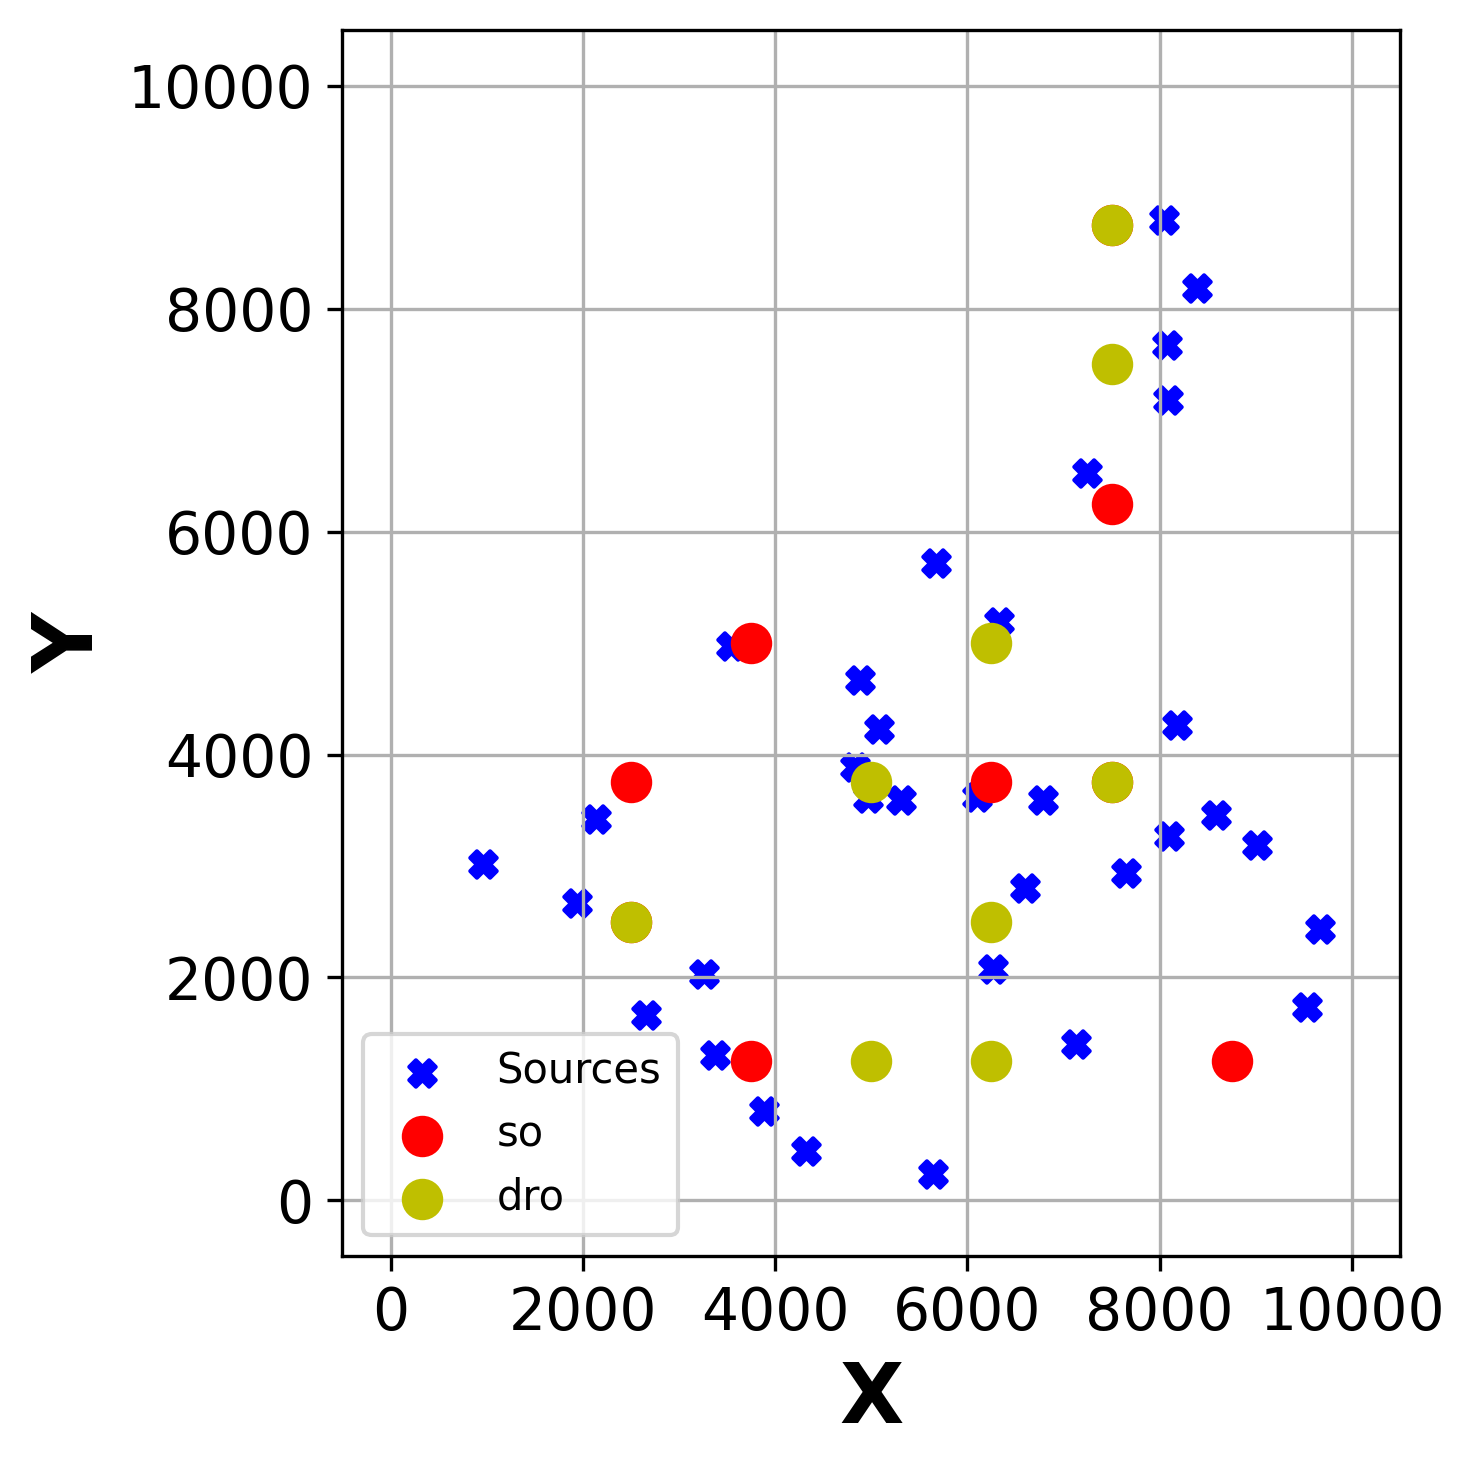

In [85]:
# import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# plt.style.use(['ieee'])
figure(figsize=(5, 5), dpi=300)
plt.grid(True)

x_leak = fault_x_noise
y_leak = fault_y_noise

plt.xlim([-500, 10500])
plt.ylim([-500, 10500])
plt.scatter(x_leak, y_leak, s=40, marker='X', c='blue', label='Sources')

type_marker = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
# plot grid strategy

geox, geoy, geoz = psarray.gridarray(9, 10000, 10000)  # extract sensor in placed positions
# plt.scatter(geox, geoy, s=100, marker='P', c='y', label='Regular network')

plt.scatter(x_so_place, y_so_place, s=80, marker='o', c='r', label='so')
plt.scatter(x_dro_place, y_dro_place, s=80, marker='o', c='y', label='dro')

# plt.scatter(geox_so_loc, geoy_so_loc, s=60, marker='*', c='g', label='Source localization Optimization')

plt.xlabel("X", fontweight='bold',  fontsize=20)
plt.ylabel("Y", fontweight='bold',  fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10, loc='lower left')
plt.tight_layout()
plt.savefig('placement_vis.png')
plt.show()
plt.close('all')